# Course 4: The `Dataset` Class for Loading Data

In this notebook, we are taking `Kaggle`'s some datasets (e.g. `EMNIST`, etc.), to display the usage of `pandas`, `numpy`, etc. and transform them into `torch.utils.data.Dataset` class, then use `DataLoader` to load the data.

The `Dataset` class is a class that loads data from a source and returns it in a consistent format. This class is used to provide a consistent way to load data from a variety of sources, such as files, databases, and web services. The `Dataset` class is a subclass of the `torch.utils.data.Dataset` class, which is a class provided by the `PyTorch` library for loading data into a neural network.

`DataLoader` is a class that loads data from a `Dataset` object and returns it in batches. The `DataLoader` class is a subclass of the `torch.utils.data.DataLoader` class, which is a class provided by the `PyTorch` library for loading data into a neural network in batches.

Above them, the `random_split` function is also a great tool for splitting the dataset into training and validation sets.

Actually, there are 3 parts in a hole dataset, including the `Training`, `Evaluation`, and `Testing` parts. The `Training` part is used to train the model, the `Evaluation` part is used to evaluate the model, and the `Testing` part is used to test the model, especially for the unseen data.

In this notebook, we will take the `EMNIST` dataset as an example to show how to load the data into the `Dataset` class, and then use the `DataLoader` to load the data in batches.

## Download the Dataset

You can log in [Kaggle](https://www.kaggle.com/) and download the dataset, then upload it to the current directory. Here, we take the [`EMNIST`](https://www.kaggle.com/datasets/crawford/emnist/data) dataset as an example. The size is 1.2 GiB. You can download it and upload it to the current directory. And the article of the dataset is uploaded in [arXiv](https://arxiv.org/pdf/1702.05373v1).

We decompress the dataset into `data/EMNIST`, which contains a `.ubyte` file, and a `.csv` file with every row representing an image.

Quote from the official website:

> Format
There are six different splits provided in this dataset and each are provided in two formats:
> 
> 1. Binary (see emnist_source_files.zip)
> 2. CSV (combined labels and images)
>    - Each row is a separate image
>    - 785 columns
>    - First column = class_label (see mappings.txt for class label definitions)
>    - Each column after represents one pixel value (784 total for a 28 x 28 image)



## Load the Dataset

Through `pandas`, we can load the `CSV` format into a `DataFrame` object. Then we can transform the `DataFrame` object into a `Dataset` object. Finally, we can use the `DataLoader` to load the data in batches.

Here, we take the `EMNIST` dataset as an example to show how to load the data into the `Dataset` class, and then use the `DataLoader` to load the data in batches.

First, we need to install these packages:

In [ ]:
!pip install pandas numpy

Then following what we learned during the IT course, we can easily load the data into the `Dataset`.

What should we know: the first column is the label, and the rest columns are the pixels of the image.

The first label is in the range of `[1, 26]`, which represents the 26 letters in the alphabet. The first 26 labels are the letters from `A` to `Z`, including the upper case and lower case.

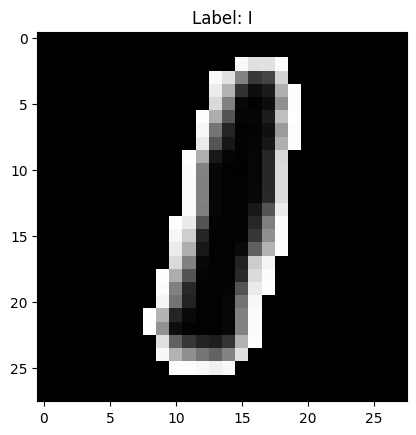

In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device('mps')

# Define the transformations
transform = transforms.Compose([
    transforms.ToPILImage(),                        # Convert the tensor to a PIL Image
    transforms.RandomRotation(degrees=(-90, -90)),  # Rotate 90 degrees clockwise
    transforms.RandomHorizontalFlip(p=1.0),         # Flip left-to-right
    transforms.ToTensor()                           # Convert the PIL Image to a tensor
])

class EMNISTDataset(Dataset):
    def __init__(self, target: str):
        self.data = pd.read_csv(target)
        self.labels = self.data.iloc[:, 0]
        self.images = self.data.iloc[:, 1:]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.images.iloc[idx].values
        label = self.labels.iloc[idx]

        image = torch.tensor(image, dtype=torch.float32).to(device)
        label = torch.tensor(label, dtype=torch.long).to(device)
        
        # Rotate clockwise 90 degrees and horizontal flip
        image = image.view(28, 28)
        image = transform(image)

        return image, label

# Load the dataset
dataset = EMNISTDataset('data/EMNIST/emnist-letters-train.csv')
# Show an example of figure
import matplotlib.pyplot as plt
from random import randint

image, label = dataset[randint(0, len(dataset))]
image = image.view(28, 28)
plt.imshow(image.cpu().numpy(), cmap='gray')
plt.title(f'Label: {chr(label + 64)}')
plt.show()


## Split the Dataset

We can split the dataset into 7-3. 70% for training and 30% for validation.

We can use the `random_split` function to split the dataset into training and validation sets. The `random_split` function takes the dataset and the lengths of the training and validation sets as arguments and returns the training and validation sets.

In [32]:
from torch.utils.data import random_split

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'Training dataset size: {len(train_dataset)}')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Training dataset size: 62159


## Use ResNet-152 for Training

In [34]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models.resnet import resnet152
from torchvision.models.resnet import ResNet152_Weights
from tqdm import tqdm

# Define the model
model = resnet152(weights = ResNet152_Weights).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
model.fc = nn.Linear(2048, 26).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

 85%|████████▍ | 825/972 [05:09<00:55,  2.66it/s]


KeyboardInterrupt: 